In [21]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.utils import img_to_array, load_img, array_to_img
from tensorflow.python.client import device_lib

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [22]:
image_size = (64, 64)  # Adjust the desired image size
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,       # Scale pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [8]:
import os
import cv2
import numpy as np
from random import randint

# Chemin vers la base de données contenant les images
database_path = "database_2"

# Nombre d'images souhaité par personne
target_image_count = 100

# Fonction pour augmenter le nombre d'images pour une personne donnée
def augment_images_for_person(person_folder):
    # Liste des fichiers d'images dans le dossier de la personne
    images = [f for f in os.listdir(person_folder) if f.endswith('.jpg') or f.endswith('.png')]
    
    # Nombre d'images existantes pour cette personne
    existing_image_count = len(images)
    
    # Si le nombre d'images existantes est inférieur à la cible, générer des images supplémentaires
    if existing_image_count < target_image_count:
        # Générer des images supplémentaires
        for i in range(target_image_count - existing_image_count):
            # Choix aléatoire d'une image existante
            image_path = os.path.join(person_folder, images[randint(0, existing_image_count - 1)])
            original_image = cv2.imread(image_path)
            
            # Exemple de modification : redimensionnement de l'image
            resized_image = cv2.resize(original_image, (100, 100))  # redimensionner à la taille souhaitée
            
            # Sauvegarder l'image augmentée
            cv2.imwrite(os.path.join(person_folder, f"augmented_{i}.jpg"), resized_image)

# Parcourir chaque dossier (représentant chaque personne) dans la base de données
for person_folder in os.listdir(database_path):
    person_folder_path = os.path.join(database_path, person_folder)
    
    # Vérifier si c'est un dossier
    if os.path.isdir(person_folder_path):
        augment_images_for_person(person_folder_path)


In [11]:
import os
import shutil
import random

# Définir les répertoires source et cible
source_directory = 'database_2'
train_directory = 'train'
test_directory = 'test'
val_directory = 'val'

# Créer les répertoires train, test et val s'ils n'existent pas déjà
os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)
os.makedirs(val_directory, exist_ok=True)

# Parcourir chaque répertoire contenant les images de chaque personne
for person_directory in os.listdir(source_directory):
    person_path = os.path.join(source_directory, person_directory)
    if os.path.isdir(person_path):
        images = os.listdir(person_path)
        random.shuffle(images)
        
        # Calculer le nombre d'images pour chaque ensemble (train, test, val)
        num_images = len(images)
        num_train = int(0.7 * num_images)
        num_test = int(0.2 * num_images)
        num_val = num_images - num_train - num_test
        
        # Répartir les images dans les répertoires train, test et val
        train_images = images[:num_train]
        test_images = images[num_train:num_train+num_test]
        val_images = images[num_train+num_test:]
        
        # Copier les images dans les répertoires appropriés
        for image in train_images:
            src = os.path.join(person_path, image)
            dst = os.path.join(train_directory, person_directory, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)
            
        for image in test_images:
            src = os.path.join(person_path, image)
            dst = os.path.join(test_directory, person_directory, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)
            
        for image in val_images:
            src = os.path.join(person_path, image)
            dst = os.path.join(val_directory, person_directory, image)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)


In [23]:
training_set = train_datagen.flow_from_directory(
    'train',         # Path to the training data directory
    target_size=image_size,  # Resize images to the specified size
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True              # Shuffle the data
)

validation_set = test_datagen.flow_from_directory(
    'val',           # Path to the validation data directory
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False             # Do not shuffle the validation data
)

test_set = test_datagen.flow_from_directory(
    'test',           # Path to the test data directory
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False             # Do not shuffle the test data
)

Found 18030 images belonging to 258 classes.
Found 2577 images belonging to 258 classes.
Found 5151 images belonging to 258 classes.


In [31]:
test_set

In [24]:
import os

# Compter le nombre de dossiers (classes) dans votre répertoire de formation
num_classes = len(os.listdir('train'))

model = Sequential()

# Convolution + Pooling Layer
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# third convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())

# Full connection
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))


# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\vlogi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 258)            │        33,282 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,642 (1.47 MB)

 Trainable params: 384,642 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(training_set,
                batch_size=32,
                epochs=25,
                validation_data=validation_set,
                )

Epoch 1/25
564/564 ━━━━━━━━━━━━━━━━━━━━ 108s 188ms/step - accuracy: 0.2669 - loss: 3.0134 - val_accuracy: 0.4354 - val_loss: 2.1514
Epoch 2/25
564/564 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.3111 - loss: 2.7566 - val_accuracy: 0.4610 - val_loss: 2.0091
Epoch 3/25
564/564 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.3597 - loss: 2.4858 - val_accuracy: 0.4757 - val_loss: 1.9706
Epoch 4/25
564/564 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.3974 - loss: 2.2923 - val_accuracy: 0.5266 - val_loss: 1.7708
Epoch 5/25
564/564 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.4569 - loss: 2.0604 - val_accuracy: 0.5409 - val_loss: 1.6837
Epoch 6/25
564/564 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.4765 - loss: 1.9861 - val_accuracy: 0.6092 - val_loss: 1.4150
Epoch 7/25
564/564 ━━━━━━━━━━━━━━━━━━━━ 50s 88ms/step - accuracy: 0.5072 - loss: 1.8325 - val_accuracy: 0.6352 - val_loss: 1.3214
Epoch 8/25
564/564 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.5316 - loss: 1.7188 

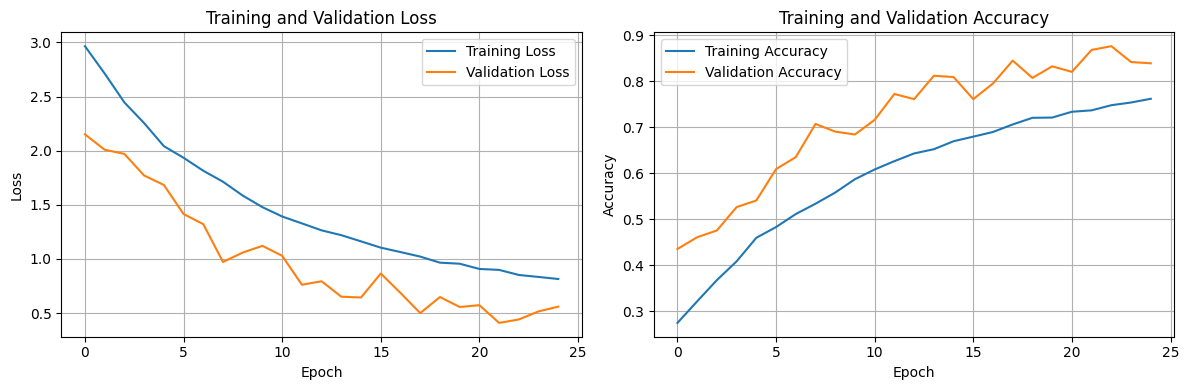

In [33]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and have a 'history' object
# history = model.fit(...)

# Plot the training loss and validation loss
plt.figure(figsize=(12, 4))  # Adjust the figure size as needed

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Customize the plot for loss
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Customize the plot for accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

In [34]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8128 - loss: 0.6896
Test loss: 0.5834, Test accuracy: 0.8290


In [39]:
y_pred = model.predict(test_set)

161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step


In [40]:
y_pred_labels = np.argmax(y_pred, axis=1)  # Assuming one-hot encoding of labels

In [41]:
y_pred_labels ## index

array([  0,   0,   0, ..., 257, 257, 257], dtype=int64)

In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import ImageTk, Image
import numpy as np
from tensorflow.keras.models import load_model
import os

# Charger le modèle pré-entraîné
model = load_model("face_version3.h5")

# Obtenir les noms de classe à partir des noms de dossiers
class_names = sorted(os.listdir("database"))

# Fonction pour charger une image et faire une prédiction
def load_and_predict():
    # Ouvrir une boîte de dialogue pour sélectionner une image
    file_path = filedialog.askopenfilename()
    
    if file_path:
        # Charger l'image
        image = Image.open(file_path)
        image = image.resize((64, 64))  # Redimensionner l'image à la taille d'entrée attendue par le modèle
        image = np.array(image) / 255.0  # Normaliser les valeurs de pixels
        image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour le lot
        prediction = model.predict(image)
        
        # Obtenir le nom de la classe prédite à partir de la probabilité maximale
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_names[predicted_class_index]
        
        # Afficher la prédiction dans une boîte de dialogue
        messagebox.showinfo("Prediction", f"Classe prédite : {predicted_class}")

# Créer une fenêtre Tkinter
root = tk.Tk()
root.title("Prédiction d'image")

# Créer un bouton pour ajouter une image
add_image_button = tk.Button(root, text="Ajouter une image", command=load_and_predict)
add_image_button.pack()

# Lancer la boucle principale Tkinter
root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


KeyboardInterrupt: 

: 

In [35]:
model.save('face_version3.h5')